In [ ]:
import pandas as pd
import numpy as np
 
import librosa        
import librosa.display 

#Dataset link provided in the Readme file check it out
csv_path = "esc50.csv"    #Download and extract dataset upload the path of ESC50.csv Path here.
audio_path =  "audio/"     # And upload the Audio file path here.
df = pd.read_csv(csv_path)
print("First five rows of dataset:")
print(df.head())
print(df['category'].value_counts())


First five rows of dataset:
            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
category
dog                 40
glass_breaking      40
drinking_sipping    40
rain                40
insects             40
laughing            40
hen                 40
engine              40
breathing           40
crying_baby         40
hand_saw            40
coughing            40
snoring             40
chirping_birds      40
toilet_flush        40
pig                 40
washing_machine     40
clock_tick          40
sneezing            40
rooster             40
sea_waves           40
siren               40
cat                

In [3]:
features = []
labels = []
for idx, row in df.iterrows():
    y, sr = librosa.load(audio_path + row['filename'], duration=5)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    features.append(mfccs_mean)
    labels.append(row['category'])

X = np.array(features)
y = np.array(labels)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [5]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

rf = RandomForestClassifier()
svm = SVC()
knn = KNeighborsClassifier()
gb = GradientBoostingClassifier()


rf.fit(X_train, y_train)
svm.fit(X_train, y_train)
knn.fit(X_train, y_train)
gb.fit(X_train, y_train)



,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [6]:

rf_acc = rf.score(X_test, y_test)
svm_acc =  svm.score(X_test, y_test)
knn_acc = knn.score(X_test, y_test)
gb_acc =  gb.score(X_test, y_test)


print("Random Forest Accuracy:",rf_acc  )
print("SVM Accuracy:",svm_acc)
print("KNN Accuracy:", knn_acc )
print("Gradient Boosting Accuracy:",gb_acc)


Random Forest Accuracy: 0.435
SVM Accuracy: 0.1425
KNN Accuracy: 0.2375
Gradient Boosting Accuracy: 0.3175


In [7]:



def make_mel_spec(filename):
    y, sr = librosa.load(audio_path + filename, duration=5)
    spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    spec_db = librosa.power_to_db(spec, ref=np.max)
    spec_db = spec_db[..., np.newaxis]   # Add channel dimension
    return spec_db


specs = []
spec_labels = []
for idx, row in df.iterrows():
    specs.append(make_mel_spec(row['filename']))
    spec_labels.append(row['category'])

specs = np.array(specs)

spec_labels = le.transform(spec_labels)

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(specs, spec_labels, test_size=0.2, random_state=42)


In [8]:
import tensorflow as tf

In [9]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, specs.shape[2], 1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(le.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(X_train_cnn, y_train_cnn, epochs=25, batch_size=16, validation_data=(X_test_cnn, y_test_cnn))  #tried with diff. epoch and decided with 25 

test_loss, cnn_acc  = cnn_model.evaluate(X_test_cnn, y_test_cnn)

print('CNN Test Accuracy:', cnn_acc )


C:\Users\shard\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.0838 - loss: 9.4942 - val_accuracy: 0.1300 - val_loss: 3.3614
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.3450 - loss: 2.6439 - val_accuracy: 0.2175 - val_loss: 3.3468
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.6269 - loss: 1.4500 - val_accuracy: 0.3050 - val_loss: 3.0721
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.8344 - loss: 0.6586 - val_accuracy: 0.3275 - val_loss: 3.4966
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.9344 - loss: 0.2983 - val_accuracy: 0.2600 - val_loss: 4.5312
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.9463 - loss: 0.2424 - val_accuracy: 0.2725 - val_loss: 4.7021
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.9750 - loss: 0.1283 - val_accuracy: 0.3025 - val_loss: 4.5653
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.9675 - loss: 0

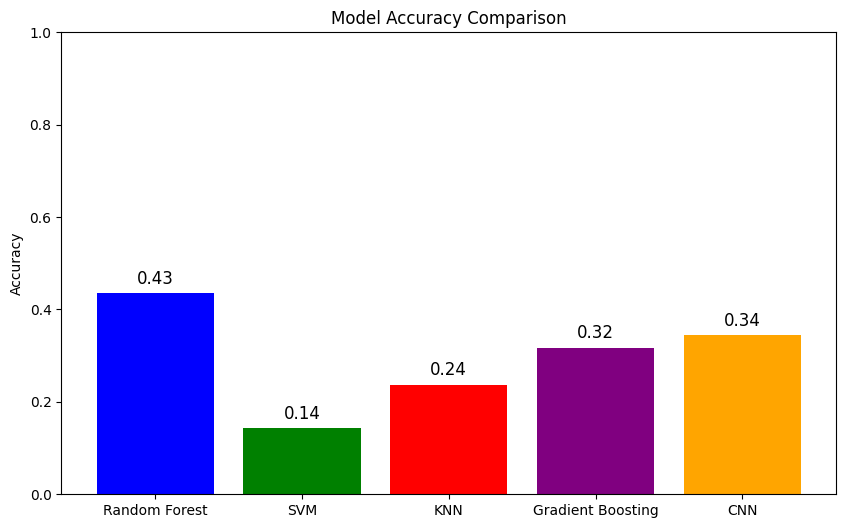

In [10]:
import matplotlib.pyplot as plt




models = ['Random Forest', 'SVM', 'KNN', 'Gradient Boosting', 'CNN']
accuracies = [rf_acc, svm_acc, knn_acc, gb_acc, cnn_acc]

# Plotting
plt.figure(figsize=(10,6))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', fontsize=12)

plt.show()


In [2]:
#Epoch: 5 , accuracy : 0.01
#Epoch: 10, accuracy : 0.29
#Epoch: 25, accuracy : 0.37
#Epoch: 50, accuracy : 0.36


In [12]:
import torch
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

C:\Users\shard\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")

Fetching 1 files: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
C:\Users\shard\anaconda3\Lib\site-packages\transformers\configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [14]:
def extract_wav2vec_features(filename):
    wav, sr = librosa.load("C:/Users/shard/Downloads/archive/audio/audio/" + filename, sr=16000)  # expects 16kHz audio 
    inputs = feature_extractor(wav, sampling_rate=16000, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = wav2vec_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()   #  to get fixed-length embedding
    return embeddings


In [15]:
features = [] 
for fn in df['filename']:
    feat = extract_wav2vec_features(fn)
    features.append(feat)
X = np.vstack(features)

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [16]:
y = le.fit_transform(df['category'])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
lR_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", lR_acc)
print(classification_report(y_test, y_pred, target_names=le.classes_))


Test Accuracy: 0.525
                  precision    recall  f1-score   support

        airplane       0.50      0.38      0.43         8
       breathing       0.80      0.50      0.62         8
  brushing_teeth       0.75      0.86      0.80         7
     can_opening       0.73      1.00      0.84         8
        car_horn       0.20      0.33      0.25         3
             cat       0.40      0.33      0.36        12
        chainsaw       0.15      0.50      0.24         4
  chirping_birds       0.38      0.50      0.43         6
    church_bells       0.40      0.50      0.44         8
        clapping       0.43      0.27      0.33        11
     clock_alarm       0.71      0.62      0.67         8
      clock_tick       0.44      0.80      0.57         5
        coughing       0.71      1.00      0.83        10
             cow       0.67      0.62      0.64        13
  crackling_fire       0.67      0.44      0.53         9
        crickets       0.33      0.17      0.22   

C:\Users\shard\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\shard\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\shard\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
